In [19]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV                                
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

### LOADING PROCESSED DATA

In [21]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '../..'))
PROCESSED_DATA_PATH = os.path.join(BASE_DIR, 'data', 'processed')

In [22]:
X_train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'X_train.csv'))
X_test = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'X_test.csv'))
y_train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'y_train.csv')).values.ravel()
y_test = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'y_test.csv')).values.ravel()

print(f"[SUCCESS] Data Loaded! Training Shape: {X_train.shape}")

[SUCCESS] Data Loaded! Training Shape: (5634, 30)


### BASELINE DECISION TREE

In [23]:
# training a "vanilla" Decision Tree to see what happens without any effort.
dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [24]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

In [25]:
# evaluating
y_pred_base = dt_baseline.predict(X_test)

print("[INFO] Baseline Decision Tree Performance: \n")
print(f"Accuracy: {accuracy_score(y_test, y_pred_base):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_base):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, dt_baseline.predict_proba(X_test)[:, 1]):.4f}")

[INFO] Baseline Decision Tree Performance: 

Accuracy: 0.7268
F1 Score: 0.4818
ROC-AUC: 0.6470


### DT - OPTIMIZING FOR ACCURACY

In [26]:
# we use a distinct variable name 'dt_acc' to avoid overwriting the previous model
dt_acc = DecisionTreeClassifier(random_state=42)

param_grid_acc = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_leaf_nodes': [None, 30, 50],           # limits tree complexity
    'class_weight': [None]                      # removing 'balanced' to prioritize raw accuracy
}

print("[INFO] Starting Grid Search for ACCURACY Model...\n")

# scoring='accuracy'
grid_search_acc = GridSearchCV(estimator=dt_acc, param_grid=param_grid_acc, 
                               cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search_acc.fit(X_train, y_train)

# get the best 'Accuracy' model
best_dt_acc = grid_search_acc.best_estimator_
print(f"\n[SUCCESS] Best Accuracy Parameters: {grid_search_acc.best_params_}")

# Evaluate
y_pred_acc = best_dt_acc.predict(X_test)
y_prob_acc = best_dt_acc.predict_proba(X_test)[:, 1]

print("\n[INFO] Accuracy-Optimized Report:\n")
print(classification_report(y_test, y_pred_acc))

[INFO] Starting Grid Search for ACCURACY Model...

Fitting 5 folds for each of 216 candidates, totalling 1080 fits



[SUCCESS] Best Accuracy Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 30, 'min_samples_leaf': 10, 'min_samples_split': 2}

[INFO] Accuracy-Optimized Report:

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



In [27]:
#accuracy
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_acc):.4f}")

#f1 score
print(f"F1 Score: {f1_score(y_test, y_pred_acc):.4f}")

#roc-auc
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_acc):.4f}")


Accuracy Score: 0.7970
F1 Score: 0.5719
ROC-AUC Score: 0.8242


### DT - OPTIMIZING FOR F1

Adding `class_weight` as balanced to help with the imbalanced data.

In [28]:
dt = DecisionTreeClassifier(random_state=42)

# The "Grid" of options to test:
param_grid = {
    'criterion': ['gini', 'entropy'],           # The math behind the split
    'max_depth': [3, 5, 7, 10, None],           # How deep the tree can go
    'min_samples_split': [2, 5, 10],            # Minimum items to allow a split
    'min_samples_leaf': [1, 2, 4],              # Minimum items in a final leaf
    'class_weight': [None, 'balanced']          # 'balanced' helps with our Imbalanced Churn data!
}

In [29]:
print("[INFO] Starting Grid Search... (finding best model settings)\n")

# scoring='f1' is crucial because we care about Churn (the minority class), not just accuracy
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_
print(f"\n[SUCCESS] Best Parameters Found: {grid_search.best_params_}")

[INFO] Starting Grid Search... (finding best model settings)

Fitting 5 folds for each of 180 candidates, totalling 900 fits

[SUCCESS] Best Parameters Found: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [30]:
y_pred = best_dt.predict(X_test)
y_prob = best_dt.predict_proba(X_test)[:, 1] # Probability for ROC-AUC

print("[INFO] Classification Report: \n")
print(classification_report(y_test, y_pred))

[INFO] Classification Report: 

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409



In [31]:
# accuracy
print(f"Decision Tree Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

#f1 score
print(f"Decision Tree Test F1 Score: {f1_score(y_test, y_pred):.4f}")

#roc-auc
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

Decision Tree Test Accuracy: 0.7410
Decision Tree Test F1 Score: 0.6194
ROC-AUC Score: 0.8321


### Confusion Matrices

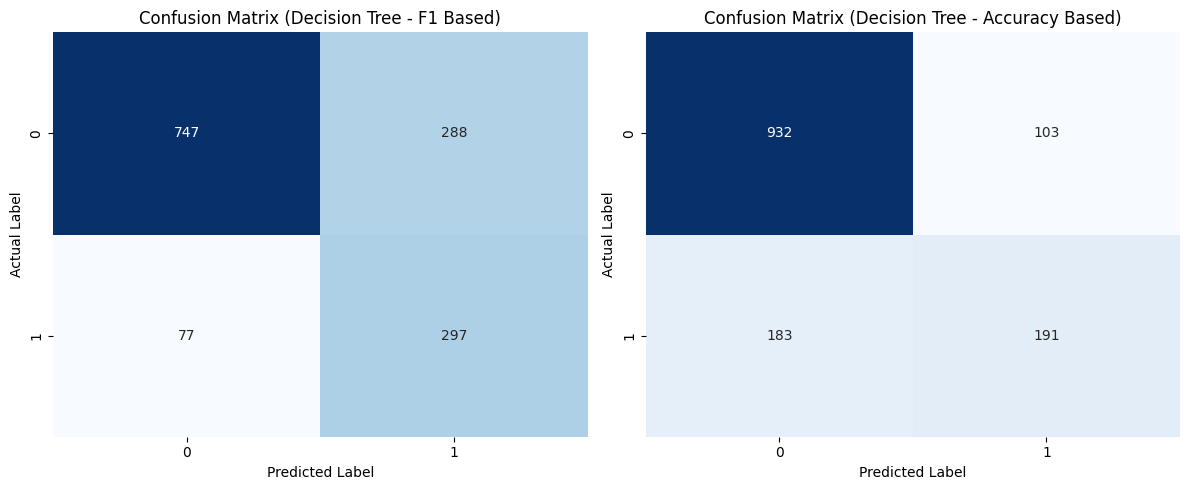

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# f1
cm1 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix (Decision Tree - F1 Based)')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('Actual Label')

# accuracy
cm2 = confusion_matrix(y_test, y_pred_acc)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title('Confusion Matrix (Decision Tree - Accuracy Based)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('Actual Label')

plt.tight_layout()
plt.show()


In [33]:
# f1
precision_f1 = precision_score(y_test, y_pred)
recall_f1 = recall_score(y_test, y_pred)
f1_f1 = f1_score(y_test, y_pred)

# acc
precision_acc = precision_score(y_test, y_pred_acc)
recall_acc = recall_score(y_test, y_pred_acc)
f1_acc = f1_score(y_test, y_pred_acc)

data = {
    "Metric": ["Precision", "Recall", "F1-Score"],
    "F1-Based Model": [precision_f1, recall_f1, f1_f1],
    "Accuracy-Based Model": [precision_acc, recall_acc, f1_acc]
}

df = pd.DataFrame(data)
print(df)


      Metric  F1-Based Model  Accuracy-Based Model
0  Precision        0.507692              0.649660
1     Recall        0.794118              0.510695
2   F1-Score        0.619395              0.571856


Since minority is important, going forward with the F1 based model.

### DT VISUALIZATION

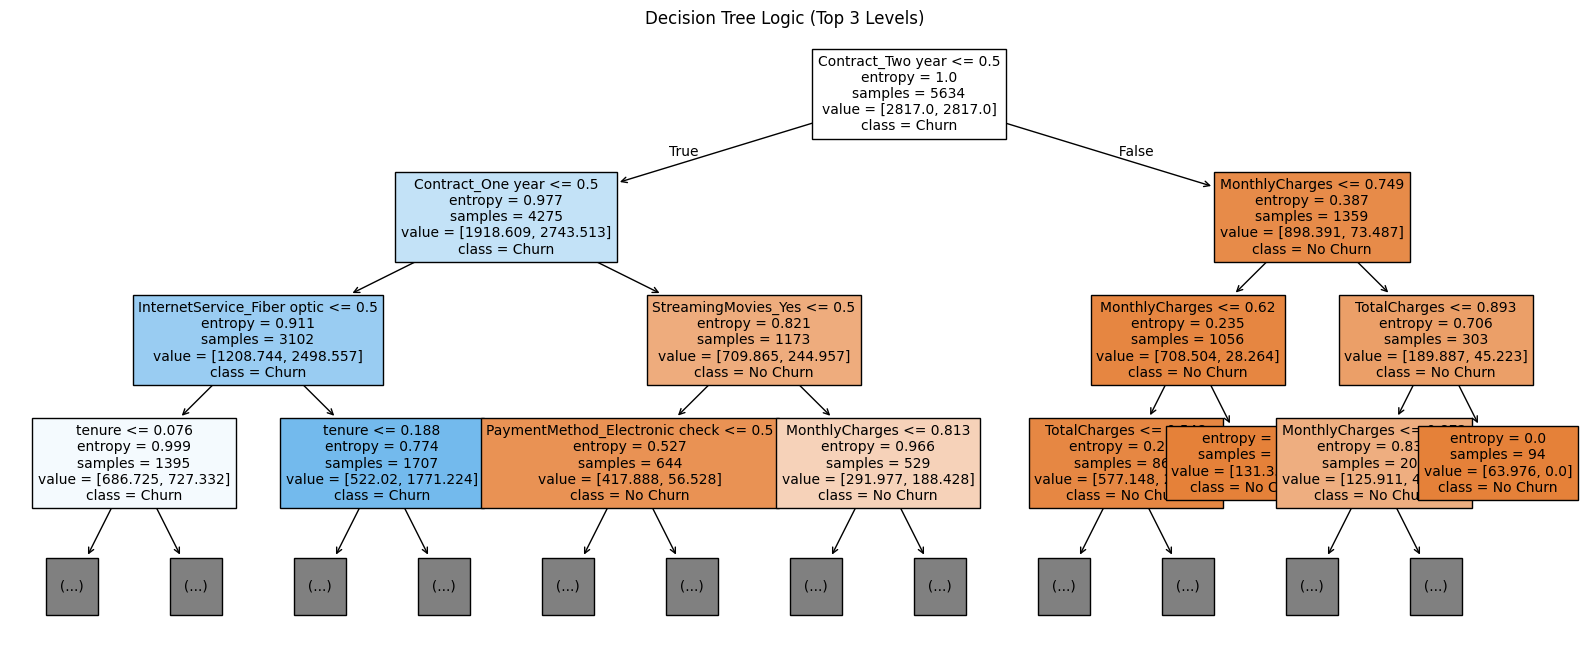

In [34]:
# visualize the top 3 levels of the tree

plt.figure(figsize=(20, 8))
plot_tree(best_dt, feature_names=X_train.columns, class_names=['No Churn', 'Churn'], 
          filled=True, max_depth=3, fontsize=10)
plt.title('Decision Tree Logic (Top 3 Levels)')
plt.show()

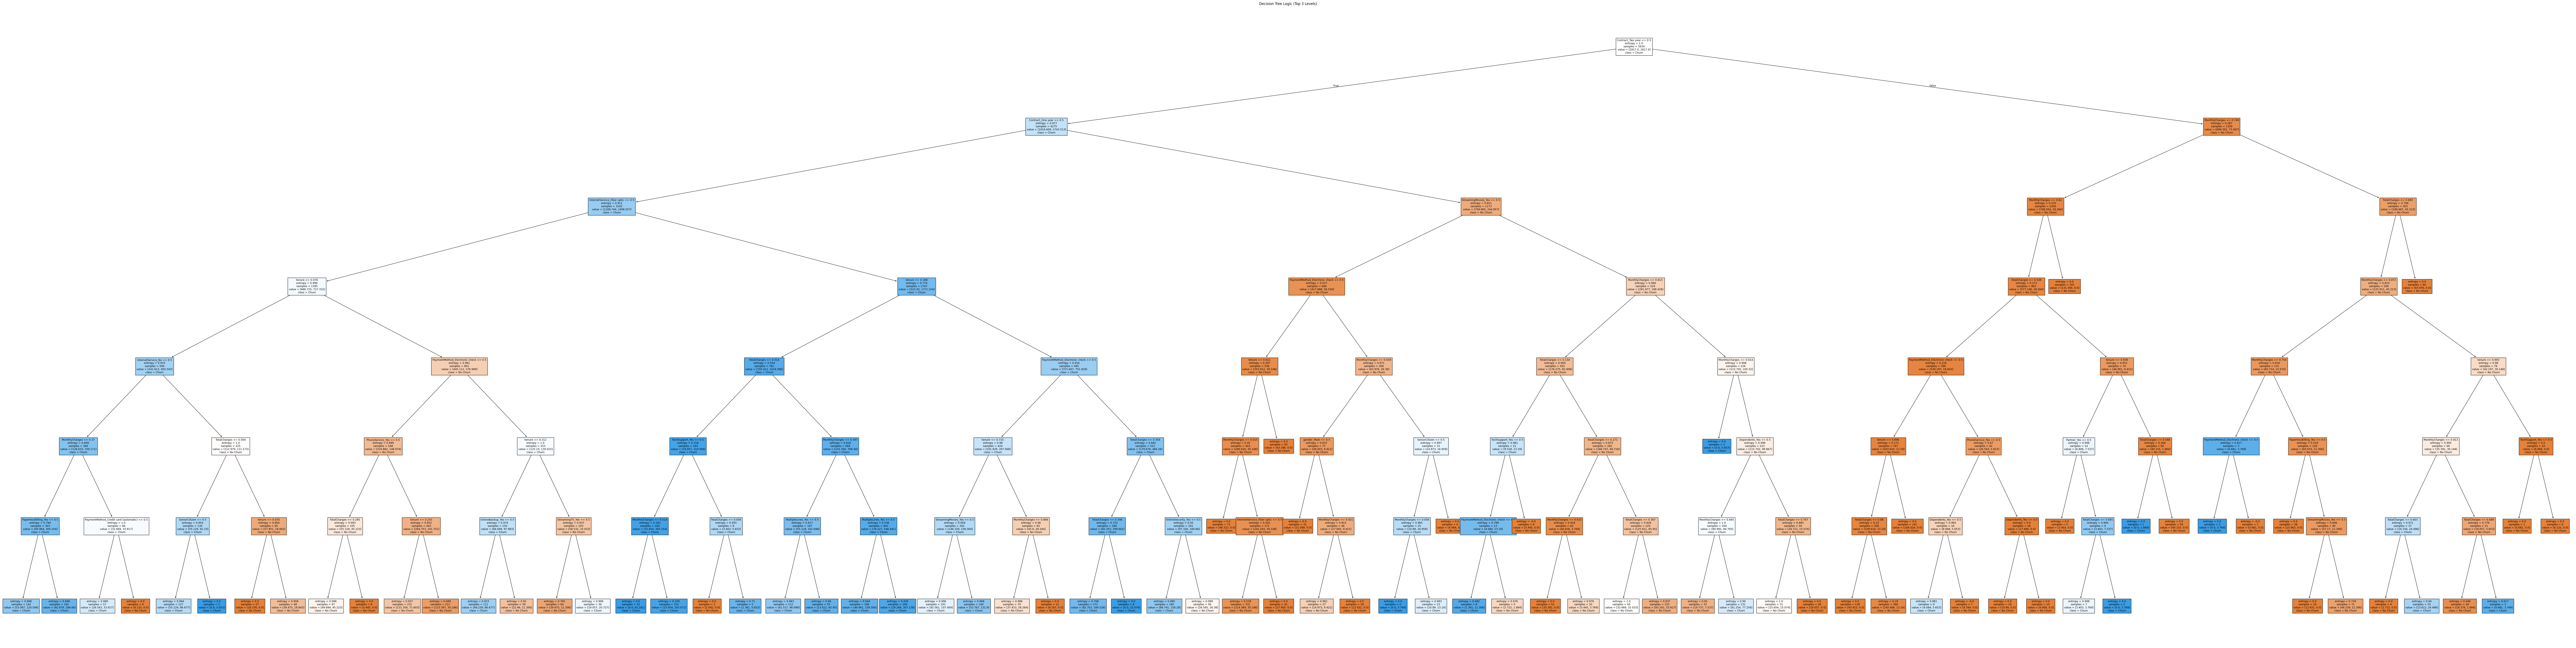

In [35]:
# visualizing the all 7 levels

plt.figure(figsize=(160, 40))
plot_tree(best_dt, feature_names=X_train.columns, class_names=['No Churn', 'Churn'], 
          filled=True, max_depth=7, fontsize=9)

plt.title('Decision Tree Logic (Top 3 Levels)')
plt.show()

### ROC CURVE VISUALIZATION

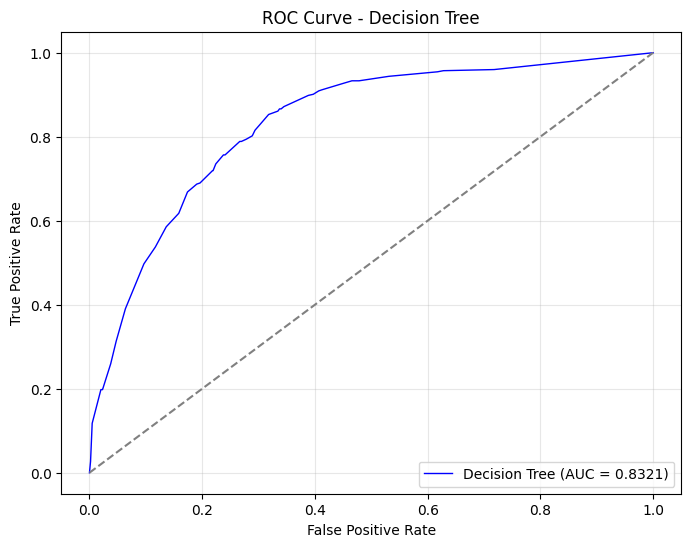

In [37]:
# getting false positive rate (fpr) and true positive rate (tpr)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))

# plot the curve
plt.plot(fpr, tpr, color='blue', lw=1, label=f'Decision Tree (AUC = {auc:.4f})')

# plot the "Random Guess" line (dashed)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

### SAVING DATA FOR COMPARISON

In [38]:
# Save probabilities for roc curve plotting
pd.DataFrame(y_prob).to_csv(os.path.join(PROCESSED_DATA_PATH, 'dt_probs.csv'), index=False)

In [39]:
import json

# calculate the specific metrics
# get F1 score specifically for "Churn" (class 1)
from sklearn.metrics import f1_score
f1_churn = f1_score(y_test, y_pred, pos_label=1)

metrics = {
    "Model": "Decision Tree",
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1-Score (Churn)": f1_churn,
    "ROC-AUC": roc_auc_score(y_test, y_prob)
}

print(metrics)

# saving to JSON
import json
with open(os.path.join(PROCESSED_DATA_PATH, 'dt_metrics.json'), 'w') as f:
    json.dump(metrics, f)

print("[SUCCESS] Decision Tree metrics and probabilities exported to data/processed/")

{'Model': 'Decision Tree', 'Accuracy': 0.7409510290986515, 'F1-Score (Churn)': 0.6193952033368092, 'ROC-AUC': 0.8320855614973262}
[SUCCESS] Decision Tree metrics and probabilities exported to data/processed/
